In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch.univariate import ARCHInMean, GARCH
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Teste ADF para PETR4.SA:
  Estatística ADF: -11.1458
  Valor-p: 0.0000
Métricas de Desempenho para PETR4.SA:
  CAPM Clássico - MSE: 3.5990, AIC: 5123.3198, BIC: 5133.5704
  GARCH-M      - MSE: 3.6172, AIC: 5041.9407, BIC: 5072.6924


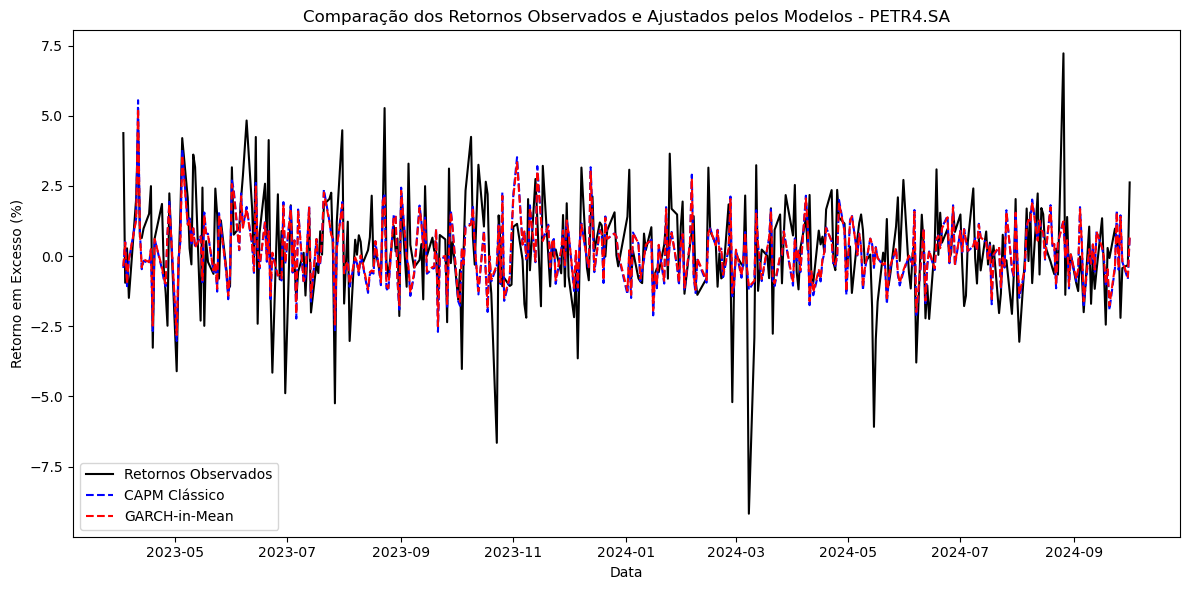

[*********************100%***********************]  1 of 1 completed


Teste ADF para PETR3.SA:
  Estatística ADF: -10.9020
  Valor-p: 0.0000
Métricas de Desempenho para PETR3.SA:
  CAPM Clássico - MSE: 3.7978, AIC: 5190.1659, BIC: 5200.4165
  GARCH-M      - MSE: 3.8245, AIC: 5122.2777, BIC: 5153.0294


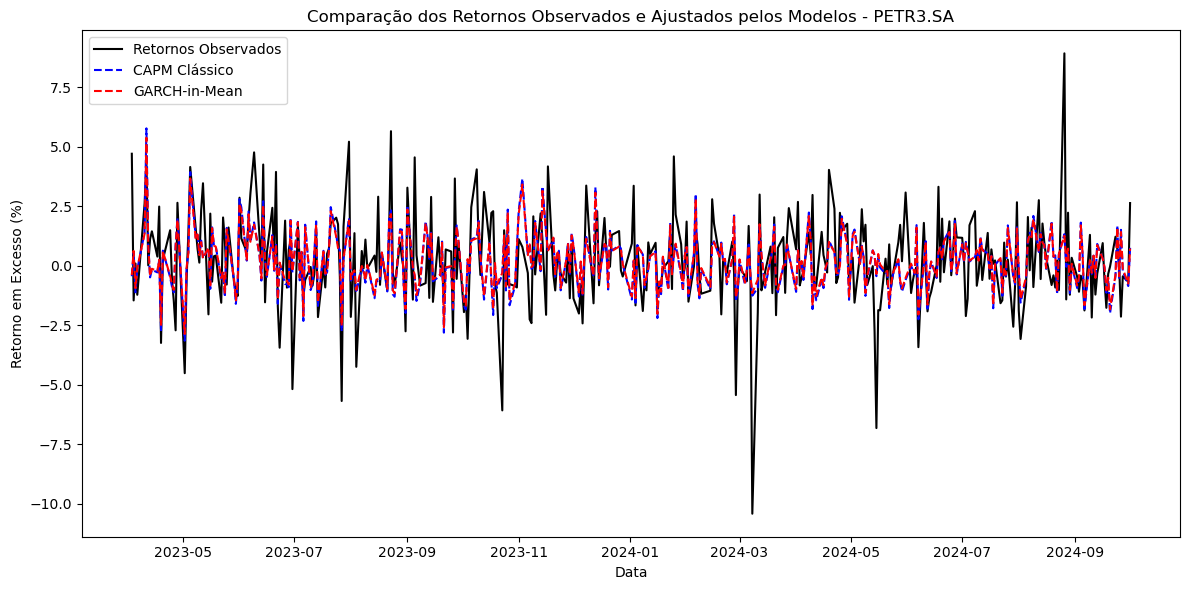

[*********************100%***********************]  1 of 1 completed


Teste ADF para VALE3.SA:
  Estatística ADF: -12.4968
  Valor-p: 0.0000
Métricas de Desempenho para VALE3.SA:
  CAPM Clássico - MSE: 3.3018, AIC: 5016.2163, BIC: 5026.4668
  GARCH-M      - MSE: 3.2912, AIC: 4906.5531, BIC: 4937.3048


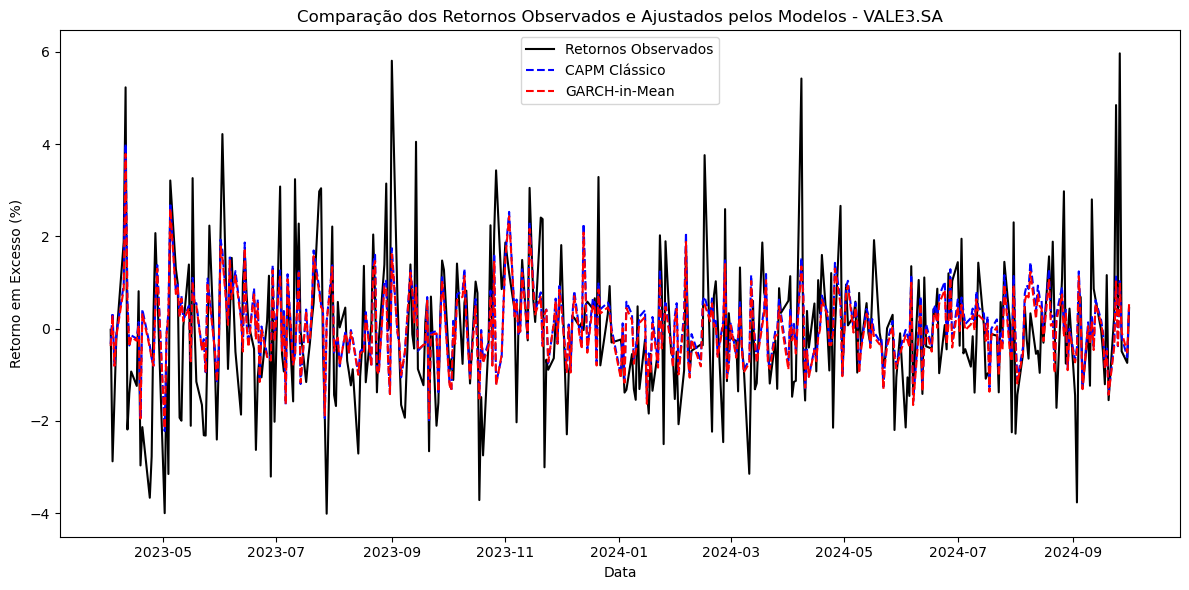

[*********************100%***********************]  1 of 1 completed


Teste ADF para ITUB4.SA:
  Estatística ADF: -9.1193
  Valor-p: 0.0000
Métricas de Desempenho para ITUB4.SA:
  CAPM Clássico - MSE: 1.7825, AIC: 4249.9597, BIC: 4260.2102
  GARCH-M      - MSE: 1.7951, AIC: 4159.6691, BIC: 4190.4208


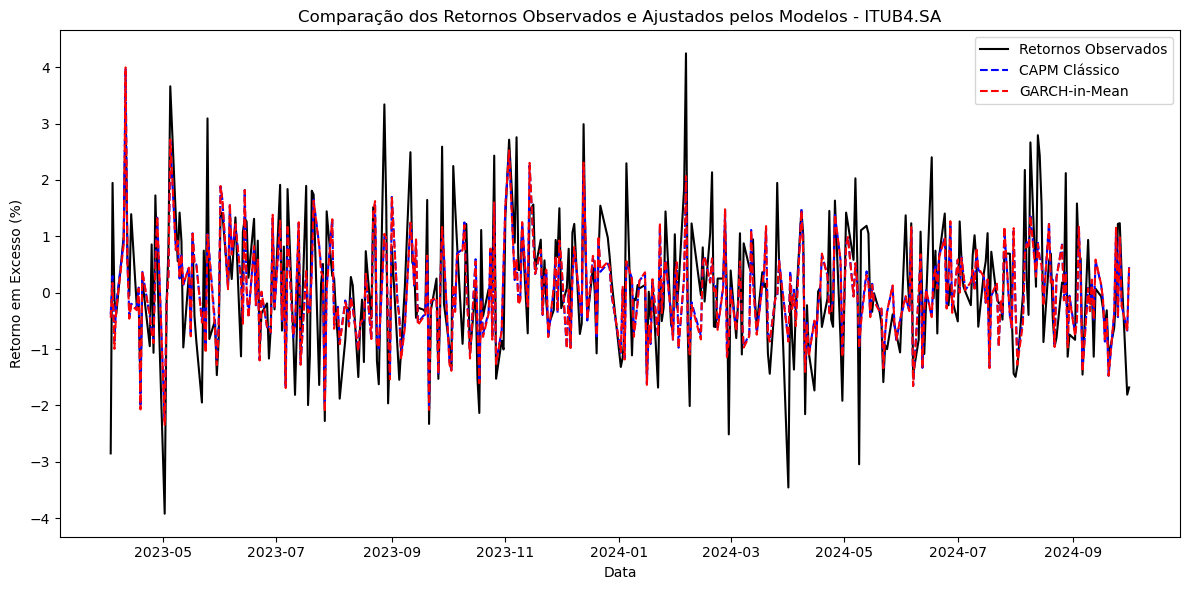

[*********************100%***********************]  1 of 1 completed


Teste ADF para BBDC4.SA:
  Estatística ADF: -9.4342
  Valor-p: 0.0000
Métricas de Desempenho para BBDC4.SA:
  CAPM Clássico - MSE: 2.3381, AIC: 4587.2027, BIC: 4597.4533
  GARCH-M      - MSE: 2.3396, AIC: 4484.8207, BIC: 4515.5724


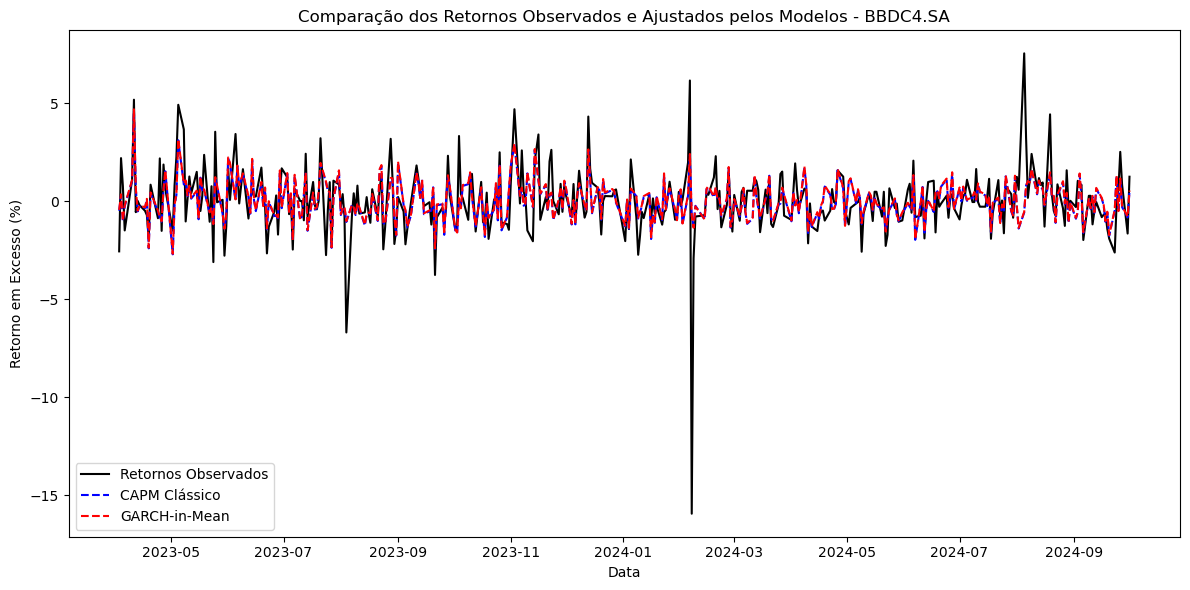

In [5]:
def analyze_and_plot(ticker, market_data, cdi_data_daily, start_date, end_date):

    

    

    stock_data = yf.download(ticker, start=start_date, end=end_date)

    

    ret_stock = stock_data['Adj Close'].pct_change().dropna()
    ret_market = market_data['Adj Close'].pct_change().dropna()
    

    if not ret_stock.index.equals(ret_market.index):
        indice_comum = ret_stock.index.intersection(ret_market.index)
        ret_stock = ret_stock.reindex(indice_comum)
        ret_market = ret_market.reindex(indice_comum)
    

    cdi_aligned = cdi_data_daily.reindex(ret_market.index).ffill()
    
    if not ret_stock.index.equals(cdi_aligned.index):
        indice_comum = ret_stock.index.intersection(cdi_aligned.index)
        ret_stock = ret_stock.reindex(indice_comum)
        ret_market = ret_market.reindex(indice_comum)
        cdi_aligned = cdi_aligned.reindex(indice_comum).ffill()
    

    data = pd.DataFrame({
        'Stock_Return': ret_stock,
        'Market_Return': ret_market,
        'CDI_Return': cdi_aligned['CDI_Return']
    }).dropna()
    

    data['Stock_Excess'] = (data['Stock_Return'] - data['CDI_Return']) * 100
    data['Market_Excess'] = (data['Market_Return'] - data['CDI_Return']) * 100
    

    adf_result = adfuller(data['Stock_Excess'])
    print(f"Teste ADF para {ticker}:")
    print(f"  Estatística ADF: {adf_result[0]:.4f}")
    print(f"  Valor-p: {adf_result[1]:.4f}")
    

    y = data['Stock_Excess']
    X = data[['Market_Excess']]
    X = sm.add_constant(X)
    

    volatility_model = GARCH(p=1, o=0, q=1)
    model_garchm = ARCHInMean(y=y, x=X, lags=0, constant=False,
                             volatility=volatility_model,
                             distribution=None,
                             form='vol')

    res_garchm = model_garchm.fit(disp='off')

    

    model_capm = sm.OLS(y, X).fit()
    

    fitted_capm = model_capm.predict(X)
    conditional_volatility = res_garchm.conditional_volatility
    params_garchm = res_garchm.params
    fitted_garchm = (
        params_garchm.get('const', 0) +
        params_garchm.get('Market_Excess', 0) * X['Market_Excess'] +
        params_garchm.get('kappa', 0) * conditional_volatility
    )
    

    mse_capm = mean_squared_error(y, fitted_capm)
    mse_garchm = mean_squared_error(y, fitted_garchm)
    
    print(f"Métricas de Desempenho para {ticker}:")
    print(f"  CAPM Clássico - MSE: {mse_capm:.4f}, AIC: {model_capm.aic:.4f}, BIC: {model_capm.bic:.4f}")
    print(f"  GARCH-M      - MSE: {mse_garchm:.4f}, AIC: {res_garchm.aic:.4f}, BIC: {res_garchm.bic:.4f}")
    

    data_inicio = '2023-04-02'
    mascara_data = y.index >= data_inicio
    
    y_plot = y.loc[mascara_data]
    fitted_capm_plot = fitted_capm.loc[mascara_data]
    fitted_garchm_plot = fitted_garchm.loc[mascara_data]
    
    plt.figure(figsize=(12,6))
    plt.plot(y_plot.index, y_plot, label='Retornos Observados', color='black')
    plt.plot(y_plot.index, fitted_capm_plot, label='CAPM Clássico', linestyle='--', color='blue')
    plt.plot(y_plot.index, fitted_garchm_plot, label='GARCH-in-Mean', linestyle='--', color='red')
    plt.legend()
    plt.title(f'Comparação dos Retornos Observados e Ajustados pelos Modelos - {ticker}')
    plt.xlabel('Data')
    plt.ylabel('Retorno em Excesso (%)')
    plt.tight_layout()
    plt.show()

def main():

    start_date = '2019-10-02'
    end_date = '2024-10-02'
    tickers = ['PETR4.SA', 'PETR3.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA']
    cdi_file = 'CDI.csv'
    


    market = yf.download('^BVSP', start=start_date, end=end_date)

    


    cdi_data = pd.read_csv(cdi_file, sep=';', parse_dates=['Date'], dayfirst=True)
    
    cdi_data.set_index('Date', inplace=True)
    cdi_data.index = pd.to_datetime(cdi_data.index, dayfirst=True)
    

    cdi_data['CDI_Return'] = cdi_data['return'].str.replace(',', '.').astype(float)
    cdi_data.drop(columns=['return'], inplace=True)
    

    cdi_data_daily = cdi_data.resample('B').ffill()
    

    for ticker in tickers:
        analyze_and_plot(ticker, market, cdi_data_daily, start_date, end_date)

if __name__ == "__main__":
    main()
